In [1]:
#pip install pgmpy

In [2]:
#pip install torch

In [3]:
#pip install plotly

In [4]:
import math 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.inference import VariableElimination 
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling

In [5]:
df0_v0 = pd.read_csv('dataset/world-happiness-report-2021.csv')

In [6]:
df1_v0 = pd.read_csv('dataset/world-happiness-report.csv')

Checking how the datasets are structured:

In [7]:
df0_v0.head() 

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.4,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.0,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.4,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798


In [8]:
df1_v0.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


Dropping the columns that are not useful for both datasets:

In [9]:
#df0 = df0_v0.copy()
df0 = df0_v0.drop(columns=['Regional indicator','upperwhisker', 'lowerwhisker', 'Standard error of ladder score', 'Explained by: Log GDP per capita', 'Explained by: Social support',
                      'Explained by: Healthy life expectancy','Ladder score in Dystopia', 'Explained by: Freedom to make life choices','Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual'])

In [10]:
df1 = df1_v0.drop(columns=['year', 'Positive affect', 'Negative affect'])

Looking for null values:

In [11]:
print("*"*30)
print("df0 null values:")
print(df0.isna().sum())
print("*"*30)
print("df1 null values:")
print(df1.isna().sum())
print("*"*30)

******************************
df0 null values:
Country name                    0
Ladder score                    0
Logged GDP per capita           0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64
******************************
df1 null values:
Country name                          0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         32
Generosity                           89
Perceptions of corruption           110
dtype: int64
******************************


In [12]:
#df1 null value remove:
df1 = df1.dropna()
#new sum for df1
print(df1.isna().sum())

Country name                        0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
dtype: int64


Changing column names:

In [13]:
df1.columns = ['CountryName', 'HappinessScore', 'GDP','SocialSupport', 'HealthyLifeExpectancy', 'FreedomToMakeLifeChoices', 'Generosity', 'PerceptionsOfCorruption']

In [14]:
df0.columns = ['CountryName', 'HappinessScore', 'GDP','SocialSupport', 'HealthyLifeExpectancy', 'FreedomToMakeLifeChoices', 'Generosity', 'PerceptionsOfCorruption']

Merging the two datasets:

In [15]:
frames = [df0, df1]
df = pd.concat(frames)

New dataset information:

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861 entries, 0 to 1948
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CountryName               1861 non-null   object 
 1   HappinessScore            1861 non-null   float64
 2   GDP                       1861 non-null   float64
 3   SocialSupport             1861 non-null   float64
 4   HealthyLifeExpectancy     1861 non-null   float64
 5   FreedomToMakeLifeChoices  1861 non-null   float64
 6   Generosity                1861 non-null   float64
 7   PerceptionsOfCorruption   1861 non-null   float64
dtypes: float64(7), object(1)
memory usage: 130.9+ KB


In [17]:
df.head()

,CountryName,HappinessScore,GDP,SocialSupport,HealthyLifeExpectancy,FreedomToMakeLifeChoices,Generosity,PerceptionsOfCorruption
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098,0.186
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030,0.179
2,Switzerland,7.571,11.117,0.942,74.4,0.919,0.025,0.292
3,Iceland,7.554,10.878,0.983,73.0,0.955,0.160,0.673
4,Netherlands,7.464,10.932,0.942,72.4,0.913,0.175,0.338


In [18]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

data = dict(type = 'choropleth', #As we have only country names in data, we can use country names to see the happiness
           locations = df['CountryName'],
           locationmode = 'country names',
           z = df['HappinessScore'], 
           text = df['CountryName'],
           colorbar = {'title':'Happiness'})
layout = dict(title = 'World Happiness Report',
             geo = dict(showframe = True,
                       projection = {'type': 'hammer'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3) 

Correlation matrix:

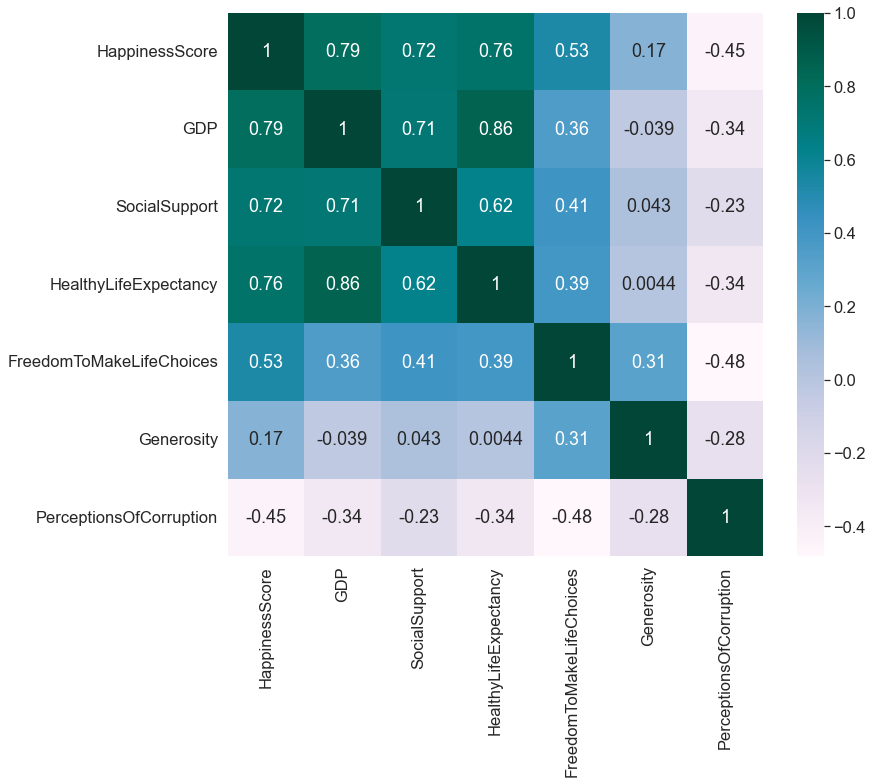

In [19]:
sns.set(font_scale=1.5)

plt.figure(figsize=(12,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="PuBuGn")

plt.show()

Variable disretizations:

In [20]:
df_discr = df.copy()  

#DISCRETIZATION HAPPINESS SCORE
h_min = int(round(df['HappinessScore'].min()))
h_max = int(round(df['HappinessScore'].max()))

boundaries = range(h_min, h_max)

df_discr['HappinessScore'] = pd.cut(df['HappinessScore'], bins=len(boundaries), right=True, labels=[1,2,3,4,5,6])

#DISCRETIZATION GDP 
GDP_min = int(round(df['GDP'].min()))
GDP_max = int(round(df['GDP'].max()))

GDP_boundaries = range(GDP_min, GDP_max)
#print(len(GDP_boundaries))

df_discr['GDP'] = pd.cut(df['GDP'], bins=len(GDP_boundaries), right=True, labels=[1,2,3,4,5])

#DISCRETIZATION SOCIAL SUPPORT 
df_discr['SocialSupport'] = pd.cut(df['SocialSupport'], bins=6, right=True, labels=[0.5,0.6,0.7,0.8,0.9,1])

#DISCRETIZATION HEALTHY LIFE EXPECTANCY
HLE_min = int(round(df['HealthyLifeExpectancy'].min()))
HLE_max = int(round(df['HealthyLifeExpectancy'].max()))

HLE_boundaries = range(HLE_min, HLE_max)
HLE_labels =[label for label in HLE_boundaries]

df_discr['HealthyLifeExpectancy'] = pd.cut(df['HealthyLifeExpectancy'], bins=len(HLE_labels), right=True, labels=HLE_labels)

#DISCRETIZATION FREEDOM TO MAKE LIFE CHOICE 
df_discr['FreedomToMakeLifeChoices'] = pd.cut(df['FreedomToMakeLifeChoices'], bins=7, right=True, labels=[0.4,0.5,0.6, 0.7,0.8,0.9,1])

#DISCRETIZATION GENEROSITY 
df_discr['Generosity'] = pd.cut(df['Generosity'], bins=9, right=True, labels=[-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5])

#DISCRETIZATION PERCEPTION OF CORRUPTION
df_discr['PerceptionsOfCorruption'] = pd.cut(df['PerceptionsOfCorruption'], bins=9, right=True, labels=[0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9])

In [21]:
print(df_discr.isnull().sum()) #no null values
df_discr

CountryName                 0
HappinessScore              0
GDP                         0
SocialSupport               0
HealthyLifeExpectancy       0
FreedomToMakeLifeChoices    0
Generosity                  0
PerceptionsOfCorruption     0
dtype: int64


,CountryName,HappinessScore,GDP,SocialSupport,HealthyLifeExpectancy,FreedomToMakeLifeChoices,Generosity,PerceptionsOfCorruption
0,Finland,6,5,1.0,71,1.0,-0.1,0.2
1,Denmark,6,5,1.0,72,1.0,0.0,0.2
2,Switzerland,6,5,1.0,74,1.0,0.0,0.3
3,Iceland,6,5,1.0,72,1.0,0.1,0.7
4,Netherlands,6,5,1.0,72,1.0,0.1,0.3
...,...,...,...,...,...,...,...,...
1944,Zimbabwe,2,2,0.9,54,0.8,-0.1,0.7
1945,Zimbabwe,2,2,0.8,54,0.8,-0.1,0.7
1946,Zimbabwe,2,2,0.9,55,0.8,-0.1,0.8
1947,Zimbabwe,1,2,0.9,56,0.7,-0.1,0.8


[[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0. 1. 0.]
 [1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0.]]


<AxesSubplot:>

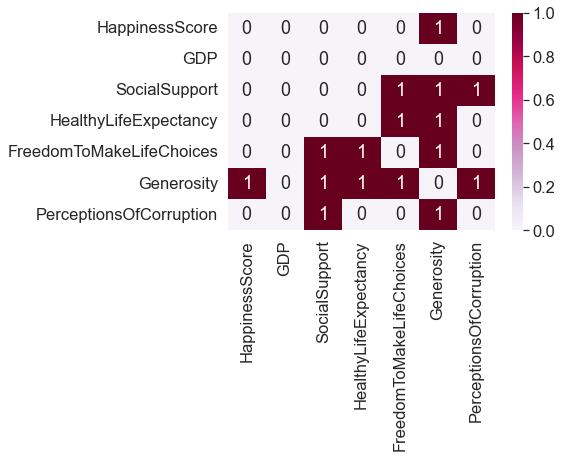

In [22]:
#CHI SQUARED TEST
from scipy.stats import chi2_contingency
from scipy.stats import chi2

size = df_discr.shape[1]
indipendence_tab = np.zeros((size-1,size-1))
indipendence_tab_p = np.zeros((size-1,size-1))

for i in range(1,size):
    for j in range(1,size):                                       
        table = pd.crosstab(df_discr.iloc[:,i], df_discr.iloc[:,j], margins=True)  #makes contingency table for each couple of columns

        stat, p, dof, expected = chi2_contingency(table)

        if abs(p) <= 1e-95: #1e-99
            indipendence_tab_p[i-1][j-1] = 0 #dependent
        else:
            indipendence_tab_p[i-1][j-1] = 1 #independent

print(indipendence_tab_p)

sns.heatmap(indipendence_tab_p,annot=True, xticklabels=df_discr.columns[1:], yticklabels=df_discr.columns[1:],cmap="PuRd")

Edges built based on the chi-squared test:

In [23]:
edges = [('GDP', 'SocialSupport'), ('GDP', 'HealthyLifeExpectancy'), ('GDP', 'FreedomToMakeLifeChoices'), ('GDP', 'Generosity'),
        ('GDP', 'HappinessScore'), ('GDP', 'PerceptionsOfCorruption'), ('SocialSupport', 'HealthyLifeExpectancy'), ('SocialSupport', 'HappinessScore'), 
         ('HealthyLifeExpectancy', 'HappinessScore'),  ('HealthyLifeExpectancy', 'PerceptionsOfCorruption'), ('FreedomToMakeLifeChoices', 'PerceptionsOfCorruption'),
        ('FreedomToMakeLifeChoices', 'HappinessScore'), ('PerceptionsOfCorruption', 'HappinessScore')]
model=BayesianNetwork(edges)

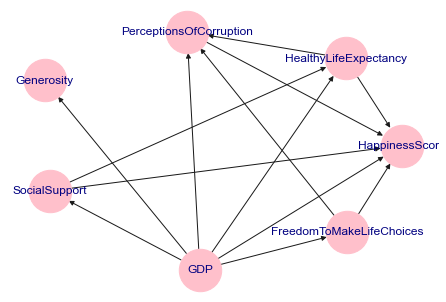

In [24]:
nx.draw(model, with_labels=True, node_color="pink", node_size=1800, font_color="navy")
plt.show()

Fitting of the model and values tests:

In [25]:
model.fit(df_discr, estimator=MaximumLikelihoodEstimator) 

In [26]:
happiness_infer = VariableElimination(model)

q = happiness_infer.query(variables=['HappinessScore'], evidence={'HealthyLifeExpectancy' : 71, 'GDP':5, 'SocialSupport':1.0, 
                                                                 'Generosity':-0.1},  joint=False) 
print(q)
print(q['HappinessScore'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'HappinessScore': <DiscreteFactor representing phi(HappinessScore:6) at 0x242c87c1790>}
+-------------------+-----------------------+
| HappinessScore    |   phi(HappinessScore) |
+===================+=======================+
| HappinessScore(1) |                0.0134 |
+-------------------+-----------------------+
| HappinessScore(2) |                0.0134 |
+-------------------+-----------------------+
| HappinessScore(3) |                0.0134 |
+-------------------+-----------------------+
| HappinessScore(4) |                0.0134 |
+-------------------+-----------------------+
| HappinessScore(5) |                0.3559 |
+-------------------+-----------------------+
| HappinessScore(6) |                0.5904 |
+-------------------+-----------------------+


In [27]:
b = happiness_infer.query(variables=['HappinessScore'], evidence={'PerceptionsOfCorruption':0.8},  joint=False) 
print(b)

print(b['HappinessScore'])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'HappinessScore': <DiscreteFactor representing phi(HappinessScore:6) at 0x242c882d0d0>}
+-------------------+-----------------------+
| HappinessScore    |   phi(HappinessScore) |
+===================+=======================+
| HappinessScore(1) |                0.0716 |
+-------------------+-----------------------+
| HappinessScore(2) |                0.1377 |
+-------------------+-----------------------+
| HappinessScore(3) |                0.2514 |
+-------------------+-----------------------+
| HappinessScore(4) |                0.2621 |
+-------------------+-----------------------+
| HappinessScore(5) |                0.1982 |
+-------------------+-----------------------+
| HappinessScore(6) |                0.0791 |
+-------------------+-----------------------+


In [28]:
res = [] 
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'Generosity':-0.3},  joint=False)) 
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'Generosity':0.5},  joint=False))
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'Generosity':-0.3, 'GDP':5},  joint=False))
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'Generosity':0.5, 'GDP':5},  joint=False))

for i in range(len(res)):
    print(res[i]['HappinessScore'])
    print()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------------+-----------------------+
| HappinessScore    |   phi(HappinessScore) |
+===================+=======================+
| HappinessScore(1) |                0.0583 |
+-------------------+-----------------------+
| HappinessScore(2) |                0.0777 |
+-------------------+-----------------------+
| HappinessScore(3) |                0.1739 |
+-------------------+-----------------------+
| HappinessScore(4) |                0.3414 |
+-------------------+-----------------------+
| HappinessScore(5) |                0.2441 |
+-------------------+-----------------------+
| HappinessScore(6) |                0.1047 |
+-------------------+-----------------------+

+-------------------+-----------------------+
| HappinessScore    |   phi(HappinessScore) |
+===================+=======================+
| HappinessScore(1) |                0.1030 |
+-------------------+-----------------------+
| HappinessScore(2) |                0.2032 |
+-------------------+------------

In [29]:
a = happiness_infer.query(variables=['SocialSupport'], evidence={'GDP' : 4},  joint=False) 
print(a)

print(a['SocialSupport'])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'SocialSupport': <DiscreteFactor representing phi(SocialSupport:6) at 0x242c8e10850>}
+--------------------+----------------------+
| SocialSupport      |   phi(SocialSupport) |
+====================+======================+
| SocialSupport(0.5) |               0.0000 |
+--------------------+----------------------+
| SocialSupport(0.6) |               0.0000 |
+--------------------+----------------------+
| SocialSupport(0.7) |               0.0000 |
+--------------------+----------------------+
| SocialSupport(0.8) |               0.0491 |
+--------------------+----------------------+
| SocialSupport(0.9) |               0.3132 |
+--------------------+----------------------+
| SocialSupport(1.0) |               0.6377 |
+--------------------+----------------------+


In [30]:
res = [] 

res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':5, 'FreedomToMakeLifeChoices':0.9},  joint=False))
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':5, 'FreedomToMakeLifeChoices':0.7},  joint=False))
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':5, 'FreedomToMakeLifeChoices':0.4},  joint=False)) 

res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':3, 'FreedomToMakeLifeChoices':0.9},  joint=False)) 
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':3, 'FreedomToMakeLifeChoices':0.7},  joint=False))
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':3, 'FreedomToMakeLifeChoices':0.4},  joint=False)) 

res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':1, 'FreedomToMakeLifeChoices':0.9},  joint=False)) 
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':1, 'FreedomToMakeLifeChoices':0.7},  joint=False))
res.append(happiness_infer.query(variables=['HappinessScore'], evidence={'GDP':1, 'FreedomToMakeLifeChoices':0.4},  joint=False)) 

for i in range(len(res)):
    print("RESULT NUM:", i)
    print(res[i]['HappinessScore'])
    print()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

RESULT NUM: 0
+-------------------+-----------------------+
| HappinessScore    |   phi(HappinessScore) |
+===================+=======================+
| HappinessScore(1) |                0.0101 |
+-------------------+-----------------------+
| HappinessScore(2) |                0.0101 |
+-------------------+-----------------------+
| HappinessScore(3) |                0.0133 |
+-------------------+-----------------------+
| HappinessScore(4) |                0.0148 |
+-------------------+-----------------------+
| HappinessScore(5) |                0.6072 |
+-------------------+-----------------------+
| HappinessScore(6) |                0.3445 |
+-------------------+-----------------------+

RESULT NUM: 1
+-------------------+-----------------------+
| HappinessScore    |   phi(HappinessScore) |
+===================+=======================+
| HappinessScore(1) |                0.1520 |
+-------------------+-----------------------+
| HappinessScore(2) |                0.1520 |
+----

Finding markov blanket for node Generosity:

In [31]:
model.get_markov_blanket('Generosity')

['GDP']

approximate inference trials

In [32]:
inference = BayesianModelSampling(model)

In [33]:
evidence = [State('GDP', 4)]

In [34]:
sample_size = 100000
samples_RS = inference.rejection_sample(evidence=evidence, size=sample_size)

prob_RS=np.mean(samples_RS['SocialSupport'], axis=0)
print(prob_RS)

  0%|          | 0/100000 [00:00<?, ?it/s]

0.8928929999997658


In [35]:
def prob_LW(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

In [36]:
sample_size = 100000
samples_LW = inference.likelihood_weighted_sample(evidence=evidence, size=sample_size)

prob_LW=prob_LW(samples_LW,'SocialSupport')
print(prob_LW)

  0%|          | 0/7 [00:00<?, ?it/s]

0.89
